# Facial Recognition and Reconstruction with Principal Component Analysis (PCA)
---

**Overview**

This notebook demonstrates how to apply Principal Component Analysis (PCA) for facial recognition and reconstruction. PCA is a powerful dimensionality reduction technique in linear algebra that transforms high-dimensional data into a lower-dimensional form. In the context of facial recognition, PCA helps in identifying the key features (**eigenfaces**) that capture the most significant variations among different faces. By projecting face images onto these eigenfaces, we can efficiently store and reconstruct facial data with reduced dimensionality.

**Objectives**

* Understand PCA: Grasp the fundamental concepts of PCA and how it applies to image data.

* Compute Eigenfaces: Learn how to derive eigenfaces from a dataset of facial images.

* Data Reduction: Utilize PCA to reduce the dimensionality of facial data, making storage and computation more efficient.

* Face Reconstruction: Reconstruct face images from their PCA-reduced representations and evaluate reconstruction quality.


### Step 1: Load the Dataset

In this step, we load and preprocess the dataset of facial images. The dataset consist of 400 grayscale images stored in the `ATTfaces/faces/` directory as `.pgm` files. We convert these images into a NumPy array to compute mathematical operations required for PCA.

**Key Actions:**

* Load Images: Read each `.pgm` file, convert it to a NumPy array, and store all images in a single NumPy array for efficient computation.

* Visualize Sample Faces: Display a grid of sample face images to get an initial sense of the data.

Dataset contains 400 images with dimensions 112*92 pixels each.


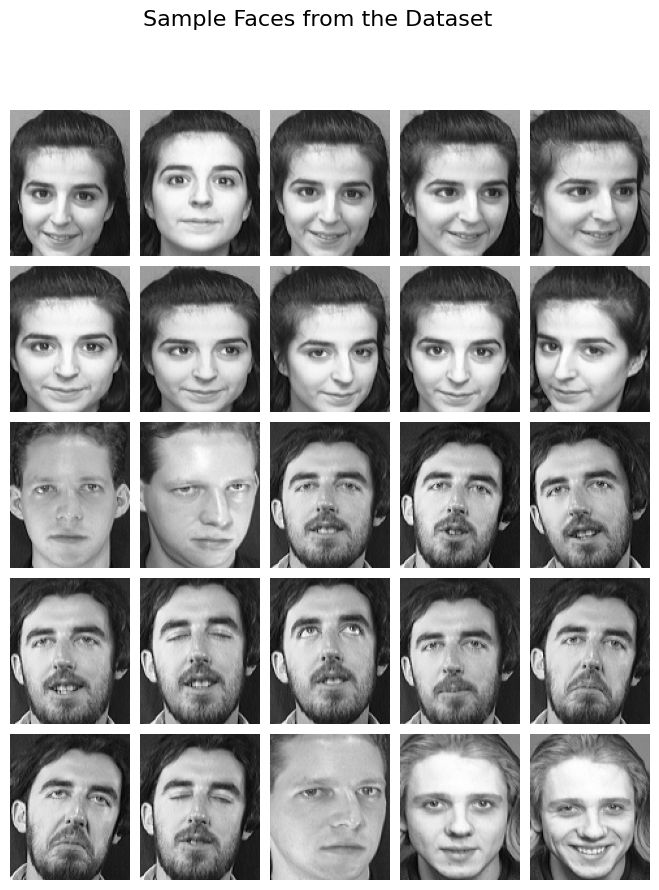

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity

# Load the files into a list from the directory
data_dir = "ATTfaces/faces/"
file_names = os.listdir(data_dir)

# Convert each image into a NumPy array and store in images
images = [np.asarray(Image.open(data_dir + file_names[i])) for i in range(len(file_names))]

# Convert the list of images into a 3D array (# of images, height, width)
images = np.array(images)

# Display image shape
print(f"Dataset contains {images.shape[0]} images with dimensions {images.shape[1]}*{images.shape[2]} pixels each.")

# Visualize some of the faces
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
fig.suptitle("Sample Faces from the Dataset", fontsize=16)

for ax, im in zip(grid, images[:25]):
    ax.imshow(im, cmap="gray")
    ax.axis('off')

plt.show()

### Step 2: Calculate the Mean Face

The mean face represents the average appearance across all faces in the dataset. Calculating the mean face provides a baseline for understanding the common features shared among the individuals in the dataset. It also serves as a reference point for computing the deviations of individual faces, which is essential for PCA.

**Key Actions:**

* Compute Mean Face: Calculate the average pixel value across all images.

* Visualize Mean Face: Display the mean face to observe the common features.

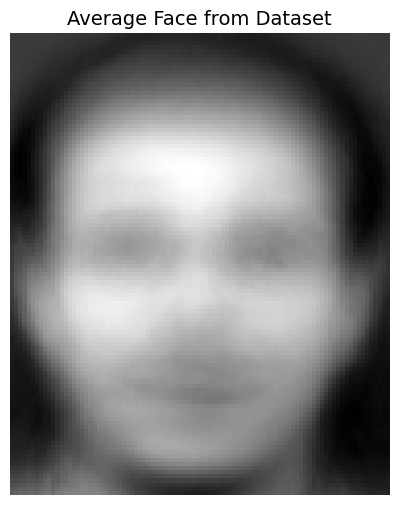

In [2]:
# Calculate the mean face by averaging pixels across all images
face_mean = images.mean(axis=0)

# Display the mean face
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(face_mean, cmap="gray")
ax.axis('off')
ax.set_title("Average Face from Dataset", fontsize=14)

plt.show()

# Principal Component Analysis (PCA)
---

Principal Component Analysis allows us to identify the most important aspects of the dataset (**eigenfaces**) and shrink each image to share similarities with those eigenfaces. While the process is lossy, we can retain almost all of the initial information, while greatly reducing the storage requirements of the dataset.

### Step 3: Prepare for Eigendecompsition

We currently have our dataset loaded and have computed the mean face. Now, we'll center the dataset by subtracting the mean face from each image. Centering the dataset ensures that hte principal components capture the directions of maximum variance (most information).

**Key Actions:**

* Center the Data: Subtract the mean face from each image.

* Reshape Data: Flatten each 2D image into a 1D vector to form a 2D data matrix for PCA.


In [3]:
# Get image dimensions
num_images, height, width = images.shape
image_size = height * width

# Flatten each image into a 1D vector
flattened_images = images.reshape(num_images, image_size)

# Compute the mean face as a 1D vector
face_mean_vector = face_mean.flatten()

# Center the data by subtracting the mean face from each image
centered_images = flattened_images - face_mean_vector

# Display the shape of the centered data matrix to verify correctness
print(f"Data matrix shape after flattening and centering: {centered_images.shape}")


Data matrix shape after flattening and centering: (400, 10304)


### Step 4: Eigendecomposition

In this step, we will compute the eigenvalues and eigenvectors of the covariance matrix. Understanding what the outputs are of these formulas is crucial as it's the backbone of PCA

**Key Concepts:**

* Eigenvectors (Principal Components): Vector directions that achieve the most variance and therefore the most information about the initial information. They represent the most significant features (**eigenfaces**) that differentiate the faces in the dataset.

* EigenValues: These are coefficients that indicate the amount of variance captured by each eigenvector. Higher eigenvalues correspond to eigenvectors that capture more variance.

**Important Points:**

* Each eigenvector is associated with one eigenvalue, establishing a one-to-one relationship between them.

* The eigenvalues are used to rank the eigenvectors in order of significance, from highest to lowest variance.

**Key Actions:**

* Compute the Covariance Matrix: With the centered data, we'll compute the covariance matrix.

* Perform Eigenvalue Decomposition: We'll compute the eigenvalues and eigenvectors of the covariance matrix using NumPy's `eigh` function.

* Sort Eigenvalues and Eigenvectors: We'll sort the eigenvalues in descending order and rearrange the eigenvectors accordingly to prioritize the principal components that capture the most variance (largest eigenvalues).

* Compute Eigenfaces: Finally, we'll transform the eigenvectors back to the original high-dimensional space to obtain the eigenfaces.

In [4]:
# Compute the covariance matrix using the trick (low-dimensional space)
cov_matrix = np.dot(centered_images, centered_images.T) / num_images

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Compute the actual eigenfaces
eigenfaces = np.dot(centered_images.T, eigenvectors)

# Normalize eigenfaces to have unit length
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

print(f"Number of eigenfaces computed: {eigenfaces.shape[1]}")


Number of eigenfaces computed: 400


### Step 5:  Eigenfaces and Normalization

Currently, we have 400 eigenvectors and eigenvalues because that's the dimensionality of our covariance matrix. To reduce the size of our dataset, we'll only keep the first **250** values.

**Key Actions:**

* Select Top Eigenfaces: Retain the first 150 eigenfaces based on the sorted eigenvalues.

* Normalize Eigenfaces: Although already normalized, we'll ensure that the eigenfaces are scaled appropriately for visualization and projection.

* Compute Weights (Coefficients): Project the centered data onto the selected eigenfaces to obtain the weights required for reconstruction.

In [5]:
# Number of principal components to retain
num_components = 150

# Select the top 'num_components' eigenfaces
selected_eigenfaces = eigenfaces[:, :num_components]
print(f"Selected {num_components} eigenfaces for further analysis.")

# Project the centered images onto the selected eigenfaces to obtain the weights (coefficients)
weights = np.dot(centered_images, selected_eigenfaces)
print(f"Weights matrix shape: {weights.shape}")


Selected 150 eigenfaces for further analysis.
Weights matrix shape: (400, 150)


### Step 6: Displaying Eigenfaces

We will visualize the top **16** eigenfaces from the **250** we've selected. This visualization helps in understanding the primary features captured by PCA and how they contribute to facial recognition.

**Key Actions:**

* Visualize Top Eigenfaces: Display the first 16 eigenfaces to observe the most significant facial features identified by PCA.

* Normalization for Visualization: Scale the eigenfaces to the [0, 1] range to enhance contrast and visibility.

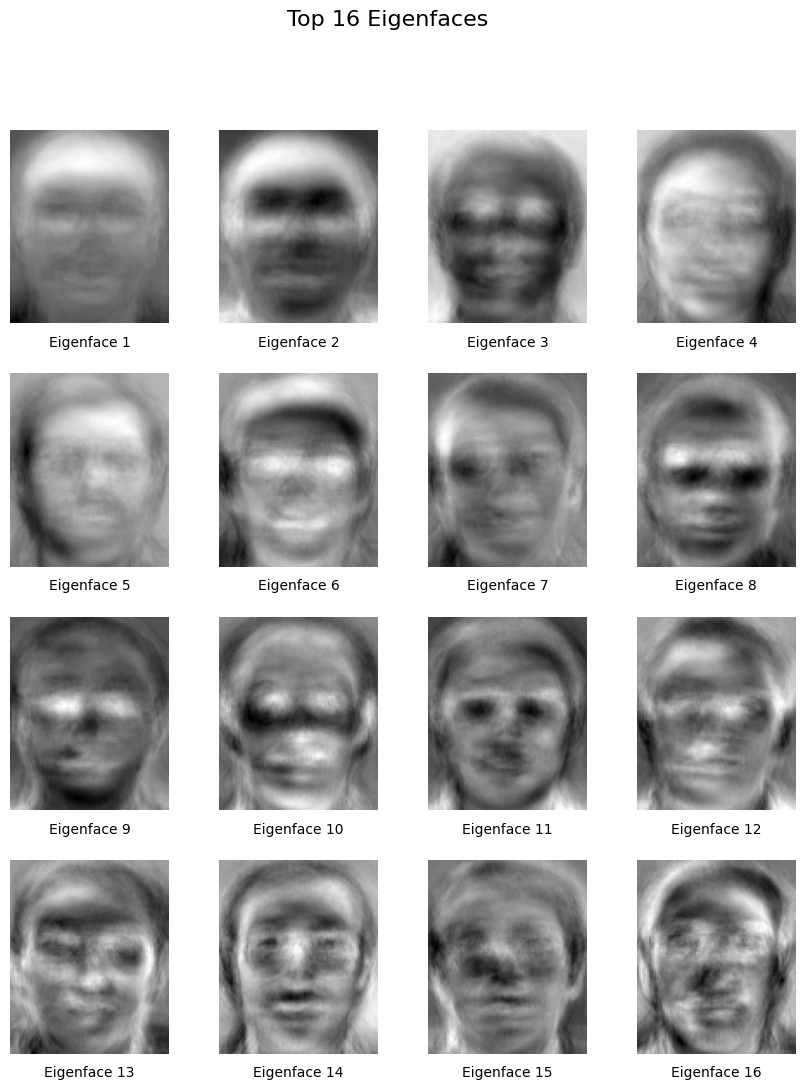

In [6]:
# Number of eigenfaces to display
num_eigenfaces_to_display = 16

# Create a figure to display eigenfaces
fig = plt.figure(figsize=(12, 12))
fig.suptitle("Top 16 Eigenfaces", fontsize=16)
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.5)

for ax, i in zip(grid, range(num_eigenfaces_to_display)):
    eigenface = selected_eigenfaces[:, i].reshape(height, width)
    # Normalize for better visualization
    eigenface_normalized = (eigenface - np.min(eigenface)) / (np.max(eigenface) - np.min(eigenface))
    ax.imshow(eigenface_normalized, cmap="gray")
    ax.axis('off')
    # Set title below the image using `ax.text`
    ax.text(
        0.5, -0.1, f"Eigenface {i+1}", 
        transform=ax.transAxes, ha='center', va='center', fontsize=10
    )

plt.show()



### Step 7: Reconstructing the images

In this step, we'll project the centered images onto the selected eigenfaces to obtain their coefficients. Using these coefficients, we'll reconstruct the images, thereby reducing the dimensionality of the data while retaining essential facial features.

**Key Actions:**

* Principal Components: Use `num_components` from PCA to reconstruct the faces.

* Project Data: Project the centered images onto the selected eigenfaces to obtain the coefficients.

* Reconstruct Images: Use the coefficients and eigenfaces to reconstruct the images.


In [7]:
# Select the top 'num_components' eigenfaces
selected_eigenfaces = eigenfaces[:, :num_components]

# Project the centered images onto the eigenfaces to get the coefficients
coefficients = np.dot(centered_images, selected_eigenfaces)

# Reconstruct the images from the coefficients and eigenfaces
reconstructed_images = np.dot(coefficients, selected_eigenfaces.T) + face_mean_vector

# Reshape reconstructed images back to original dimensions
reconstructed_images = reconstructed_images.reshape(num_images, height, width)

print(f"Reconstructed images shape: {reconstructed_images.shape}")

Reconstructed images shape: (400, 112, 92)


### Step 8: Analyzing Reconstruction Quality

After reconstructing the images, it's essential to evaluate how well the reconstructed images match the original ones. We'll assess the reconstruction quality using multiple similarity metrics:

* Pearson Correlation Coefficient

* Mean Squared Error (MSE)

* Structural Similarity Index (SSIM)

* Cosine Similarity

Additionally, we'll compute the average of these metrics across the entire dataset and display selected examples to qualitatively assess the reconstruction quality.

**Key Actions:**

* Compute Similarity Metrics: For each image, compute the four similarity metrics.

* Average Metrics: Calculate the average of each metric across the entire dataset.

* Visualize Selected Reconstructions: Display a subset of original and reconstructed images side by side, along with their individual similarity metrics.

* Compute Data Size Reduction: Evaluate the effectiveness of PCA in reducing data size.

Average Pearson Correlation Coefficient: 0.9732
Average Mean Squared Error (MSE): 109.9097
Average Structural Similarity Index (SSIM): 0.7967
Average Cosine Similarity: 0.9962


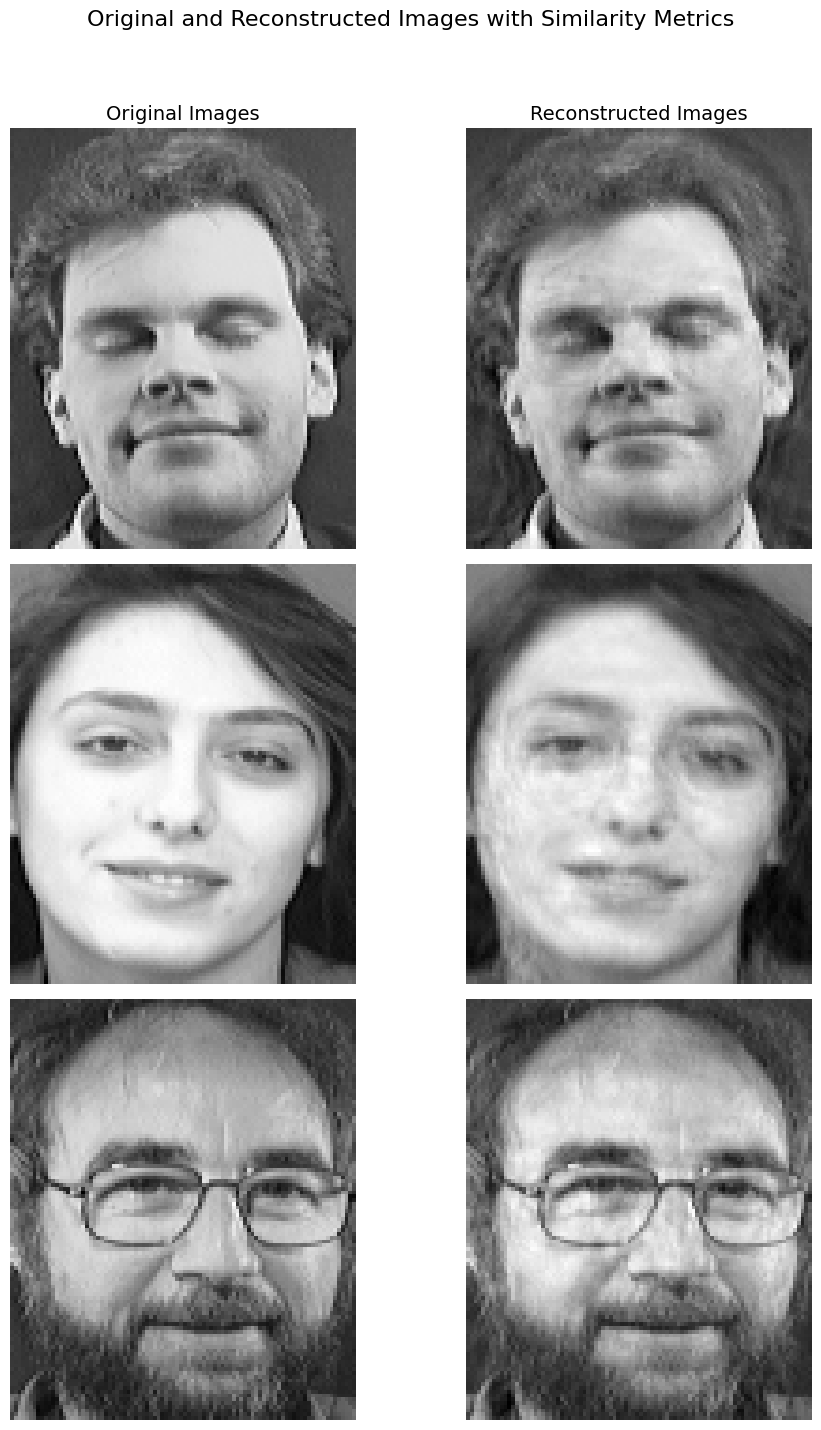

Original Data Size: 32.97 MB
Compressed Data Size: 12.36 MB
Size Reduction: 62.50%


In [20]:
# Initialize lists to store similarity metrics
correlation_coefficients = []
mse_list = []
ssim_list = []
cosine_similarities = []

# Compute similarity metrics for each image
for i in range(num_images):
    original_flat = images[i].flatten()
    reconstructed_flat = reconstructed_images[i].flatten()
    
    # Pearson Correlation Coefficient
    correlation = np.corrcoef(original_flat, reconstructed_flat)[0, 1]
    correlation_coefficients.append(correlation)
    
    # Mean Squared Error (MSE)
    mse = np.mean((original_flat - reconstructed_flat) ** 2)
    mse_list.append(mse)
    
    # Structural Similarity Index (SSIM)
    ssim_value = ssim(images[i], reconstructed_images[i], data_range=images[i].max() - images[i].min())
    ssim_list.append(ssim_value)
    
    # Cosine Similarity
    cosine_sim = cosine_similarity(original_flat.reshape(1, -1), reconstructed_flat.reshape(1, -1))[0, 0]

    # Reshape for sklearn's cosine_similarity
    cosine_similarities.append(cosine_sim)

# Compute average of each similarity metric
average_correlation = np.mean(correlation_coefficients)
average_mse = np.mean(mse_list)
average_ssim = np.mean(ssim_list)
average_cosine_similarity = np.mean(cosine_similarities)

print(f"Average Pearson Correlation Coefficient: {average_correlation:.4f}")
print(f"Average Mean Squared Error (MSE): {average_mse:.4f}")
print(f"Average Structural Similarity Index (SSIM): {average_ssim:.4f}")
print(f"Average Cosine Similarity: {average_cosine_similarity:.4f}")

# Select 6 random indices for visualization
num_display = 6
random_indices = np.random.choice(num_images, num_display, replace=False)

# Subset of images to display
images_to_display = images[random_indices]
reconstructed_images_to_display = reconstructed_images[random_indices]
selected_correlations = [correlation_coefficients[i] for i in random_indices]
selected_mse = [mse_list[i] for i in random_indices]
selected_ssim = [ssim_list[i] for i in random_indices]
selected_cosine = [cosine_similarities[i] for i in random_indices]

# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
fig.suptitle("Original and Reconstructed Images with Similarity Metrics", fontsize=16)

for idx, ax in enumerate(axes.flatten()):
    # Determine if the subplot is for the original or reconstructed image
    if idx % 2 == 0:
        # Original image
        ax.imshow(images_to_display[idx // 2], cmap="gray")
        ax.axis('off')
        if idx == 0:
            ax.set_title("Original Images", fontsize=14)
    else:
        # Reconstructed image
        ax.imshow(reconstructed_images_to_display[idx // 2], cmap="gray")
        ax.axis('off')
        if idx == 1:
            ax.set_title("Reconstructed Images", fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Compute size reductions in bytes
original_size = centered_images.nbytes
compressed_size = eigenfaces[:, :num_components].nbytes
size_reduction = (1 - compressed_size / original_size) * 100
print(f"Original Data Size: {original_size / 1e6:.2f} MB")
print(f"Compressed Data Size: {compressed_size / 1e6:.2f} MB")
print(f"Size Reduction: {size_reduction:.2f}%")


### Step 9: Analyzing the Impact of Principal Components on Similarity Metrics

Understanding how the number of principal components affects the reconstruction quality is crucial for balancing between data compression and fidelity. In this analysis, we'll observe how varying the number of principal components influences the similarity metrics: Pearson Correlation Coefficient, Mean Squared Error (MSE), Structural Similarity Index (SSIM), and Cosine Similarity.

**Key Actions:**

* Vary Number of Principal Components: Test different numbers of principal components to observe their effect on reconstruction quality.

* Compute Metrics for Each Configuration: For each number of components, reconstruct the images and compute the similarity metrics.

* Plot the Results: Visualize how each metric changes with the number of principal components.

Components: 50 | Avg Correlation: 0.9311 | Avg MSE: 285.57 | Avg SSIM: 0.6273 | Avg Cosine Sim: 0.9900
Components: 100 | Avg Correlation: 0.9592 | Avg MSE: 169.87 | Avg SSIM: 0.7295 | Avg Cosine Sim: 0.9941
Components: 150 | Avg Correlation: 0.9732 | Avg MSE: 109.91 | Avg SSIM: 0.7967 | Avg Cosine Sim: 0.9962
Components: 200 | Avg Correlation: 0.9826 | Avg MSE: 70.49 | Avg SSIM: 0.8504 | Avg Cosine Sim: 0.9975
Components: 250 | Avg Correlation: 0.9892 | Avg MSE: 42.96 | Avg SSIM: 0.8960 | Avg Cosine Sim: 0.9985
Components: 300 | Avg Correlation: 0.9940 | Avg MSE: 23.14 | Avg SSIM: 0.9359 | Avg Cosine Sim: 0.9992
Components: 350 | Avg Correlation: 0.9976 | Avg MSE: 8.99 | Avg SSIM: 0.9716 | Avg Cosine Sim: 0.9997
Components: 400 | Avg Correlation: 0.9997 | Avg MSE: 1.23 | Avg SSIM: 0.9958 | Avg Cosine Sim: 1.0000


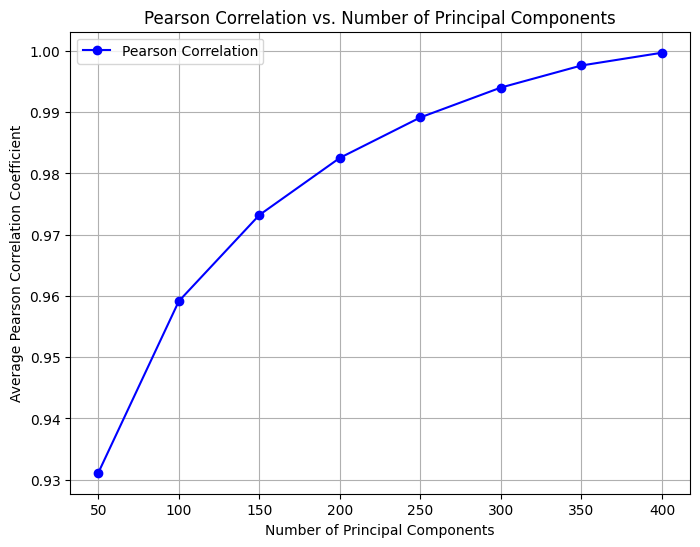

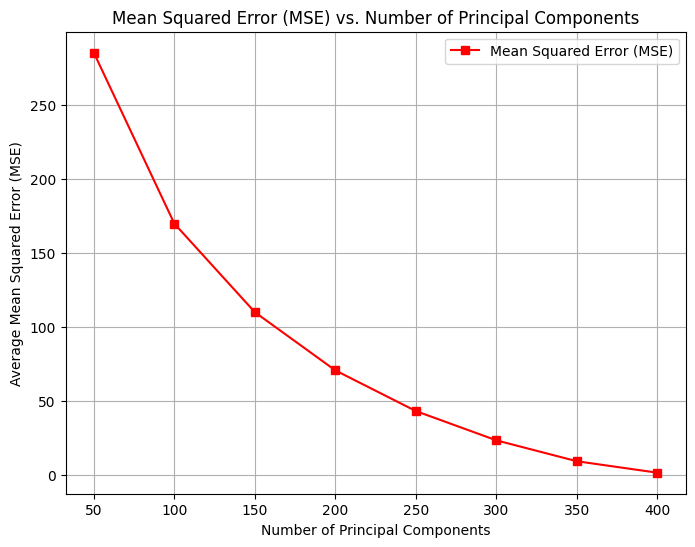

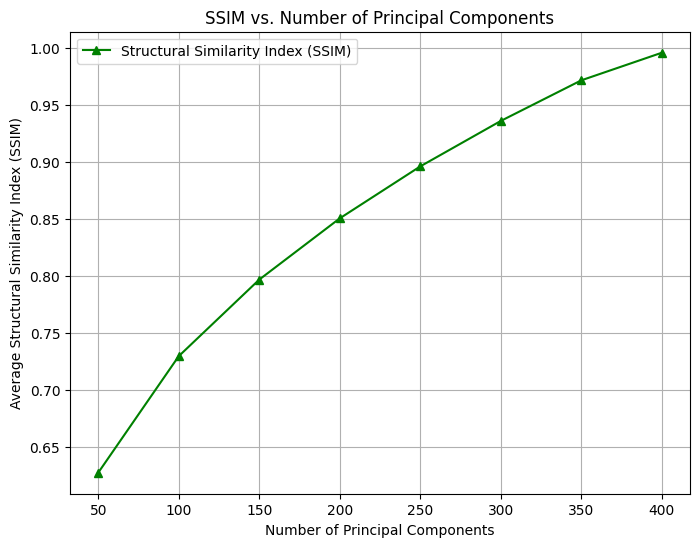

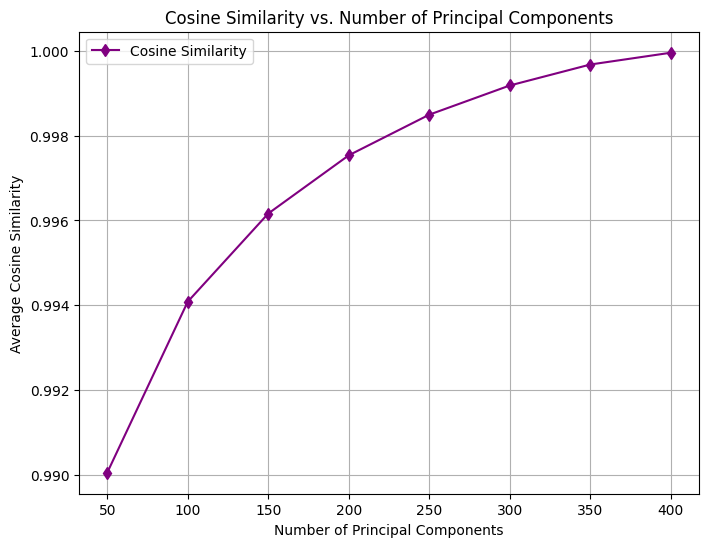

In [ ]:
# Define a range of principal components to evaluate
components_list = [50, 100, 150, 200, 250, 300, 350, 400]

# Initialize lists to store average metrics
average_correlations = []
average_mse_values = []
average_ssim_values = []
average_cosine_similarities = []

for num in components_list:
    # Select the top 'num' eigenfaces
    selected_eigenfaces = eigenfaces[:, :num]
    
    # Project the centered images onto the eigenfaces to get the coefficients
    coefficients = np.dot(centered_images, selected_eigenfaces)
    
    # Reconstruct the images from the coefficients and eigenfaces
    reconstructed = np.dot(coefficients, selected_eigenfaces.T) + face_mean_vector
    reconstructed = reconstructed.reshape(num_images, height, width)
    
    # Initialize lists to store metrics for current number of components
    correlations = []
    mses = []
    ssims = []
    cosine_sims = []
    
    for i in range(num_images):
        original_flat = images[i].flatten()
        reconstructed_flat = reconstructed[i].flatten()
        
        # Pearson Correlation Coefficient
        corr = np.corrcoef(original_flat, reconstructed_flat)[0, 1]
        correlations.append(corr)
        
        # Mean Squared Error (MSE)
        mse = np.mean((original_flat - reconstructed_flat) ** 2)
        mses.append(mse)
        
        # Structural Similarity Index (SSIM)
        ssim_val = ssim(images[i], reconstructed[i], data_range=images[i].max() - images[i].min())
        ssims.append(ssim_val)
        
        # Cosine Similarity
        cosine_sim = cosine_similarity(original_flat.reshape(1, -1), reconstructed_flat.reshape(1, -1))[0, 0]
        cosine_sims.append(cosine_sim)
    
    # Append average metrics for current number of components
    average_correlations.append(np.mean(correlations))
    average_mse_values.append(np.mean(mses))
    average_ssim_values.append(np.mean(ssims))
    average_cosine_similarities.append(np.mean(cosine_sims))
    
    print(f"Components: {num} | Avg Correlation: {average_correlations[-1]:.4f} | Avg MSE: {average_mse_values[-1]:.2f} | Avg SSIM: {average_ssim_values[-1]:.4f} | Avg Cosine Sim: {average_cosine_similarities[-1]:.4f}")

# Pearson Correlation Coefficient
plt.figure(figsize=(8, 6))
plt.plot(components_list, average_correlations, marker='o', color='blue', label='Pearson Correlation')
plt.xlabel('Number of Principal Components')
plt.ylabel('Average Pearson Correlation Coefficient')
plt.title('Pearson Correlation vs. Number of Principal Components')
plt.grid(True)
plt.legend()
plt.show()

# Mean Squared Error (MSE)
plt.figure(figsize=(8, 6))
plt.plot(components_list, average_mse_values, marker='s', color='red', label='Mean Squared Error (MSE)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title('Mean Squared Error (MSE) vs. Number of Principal Components')
plt.grid(True)
plt.legend()
plt.show()

# Structural Similarity Index (SSIM)
plt.figure(figsize=(8, 6))
plt.plot(components_list, average_ssim_values, marker='^', color='green', label='Structural Similarity Index (SSIM)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Average Structural Similarity Index (SSIM)')
plt.title('SSIM vs. Number of Principal Components')
plt.grid(True)
plt.legend()
plt.show()

# Cosine Similarity
plt.figure(figsize=(8, 6))
plt.plot(components_list, average_cosine_similarities, marker='d', color='purple', label='Cosine Similarity')
plt.xlabel('Number of Principal Components')
plt.ylabel('Average Cosine Similarity')
plt.title('Cosine Similarity vs. Number of Principal Components')
plt.grid(True)
plt.legend()
plt.show()


